In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras import layers
import sys
sys.path.insert(1, "Informer-Tensorflow/models")
sys.path.insert(1, "Informer-Tensorflow")

2023-07-08 10:25:15.157841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from attn import ProbAttention, AttentionLayer

In [3]:
class MultiHeadProbAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadProbAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.attn = AttentionLayer(ProbAttention(False), self.d_model, self.num_heads)
    def call(self, inputs):
        query = inputs
        key = inputs
        value = inputs
        x = self.attn([query, key, value])
        return x


In [4]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        # self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    # def compute_mask(self, *args, **kwargs):
    #     return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        # x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [5]:
class ConvLayer(keras.layers.Layer):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = tf.keras.layers.Conv1D(
                                  filters=c_in,
                                  kernel_size=3,
                                  padding='causal')
        self.norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ELU()
        self.maxPool = tf.keras.layers.MaxPool1D(pool_size=3)#, strides=2)

    def call(self, x, **kargs):
        x = self.downConv(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        return x

In [6]:
BATCH_SIZE = 2
def models():
    inputs = keras.layers.Input(shape=(2000,1), batch_size=BATCH_SIZE)
    # x = keras.layers.Dense(32, activation="tanh")(inputs)
    x = keras.layers.Conv1D(32, 1, activation='tanh')(inputs)
    x = PositionalEmbedding(32)(x)
    x = MultiHeadProbAttention(128, 32)(x)
    x = ConvLayer(64)(x)
    x = MultiHeadProbAttention(64, 32)(x)
    x = ConvLayer(32)(x)
    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    x = keras.layers.Dense(5, activation='softmax')(x)
    return keras.Model(inputs, x)

In [7]:
model = models()
model.summary()
# del model

2023-07-08 10:25:18.805740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22250 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6


[TensorShape([2, 2000, 32]), TensorShape([2, 2000, 32]), TensorShape([2, 2000, 32])]
[TensorShape([2, 666, 64]), TensorShape([2, 666, 64]), TensorShape([2, 666, 64])]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(2, 2000, 1)]            0         
                                                                 
 conv1d (Conv1D)             (2, 2000, 32)             64        
                                                                 
 positional_embedding (Posit  (2, 2000, 32)            0         
 ionalEmbedding)                                                 
                                                                 
 multi_head_prob_attention (  (2, 2000, 128)           29184     
 MultiHeadProbAttention)                                         
                                                                 
 conv_layer (ConvLayer)   

In [8]:
x = tf.random.normal((BATCH_SIZE, 2000, 1))
model(x)

2023-07-08 10:25:21.250572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-08 10:25:21.496814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.19999997, 0.19999997, 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.19999997, 0.19999997, 0.2       , 0.2       ]],
      dtype=float32)>

In [9]:
data = np.load("data_shuffled.npz")
X = data["X"]
Y = data["Y"]

x_train = tf.reshape(X[0:850], (-1, 2000, 1))
y_train = Y[0:850]
x_test = tf.reshape(X[850:], (-1, 2000, 1))
y_test = Y[850:]

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=100000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [11]:
x = x_train[0:BATCH_SIZE]
x_rank = tf.rank(x).numpy()
x_norm_resize_shape = [BATCH_SIZE] + list(tf.ones(tf.rank(x), dtype=tf.int32).numpy())[1:]

In [12]:
def perturbation_loss(x, y, from_logits=False):
    return keras.losses.CategoricalCrossentropy(from_logits=from_logits)(x, y)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [13]:
eps = 8.     # the perturbation parameter
sig = 1e-5   # initial perturbation StdDev
zeta = 1e-6  # differentiation constant
lamd = 1     # regularization parameter

@tf.function
def training_step(x, label):
    x_p = tf.random.normal((BATCH_SIZE,2000, 1), stddev=sig)
    x_norm = x_p
    for i in range(x_rank-1, 0, -1):
        x_norm = tf.norm(x_norm, ord=2, axis=int(i))
    x_p /= tf.reshape(x_norm, (BATCH_SIZE, 1, 1))
    x_p *= zeta


    with tf.GradientTape() as model_tape, tf.GradientTape() as perturbation_tape:
        perturbation_tape.watch(x_p)
        y_p = model(x + x_p, training=True)
        y = model(x, training=True)
        l = perturbation_loss(y, y_p)
        g = perturbation_tape.gradient(l, x_p)

        g_norm = g
        for i in range(x_rank-1, 0, -1):
            g_norm = tf.norm(g_norm, ord=2, axis=int(i))

        x_p = eps * g / tf.reshape(g_norm, x_norm_resize_shape)

        logits = model(x, training=True)
        loss = loss_fn(label, logits) + lamd * l / BATCH_SIZE
        grads = model_tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(label, logits)
    return loss, train_acc_metric.result(), l, x_p, g

In [23]:
train_loss = []
train_metric = []
val_metric = []
p_loss = []
for epoch in tqdm(range(100)):
    print("\nStart of epoch %d" % (epoch,))
    for step, (x, label) in enumerate(train_dataset):
        loss, train_acc, l, x_p, g = training_step(x, label)

    print(
        "Training loss: %.4f\nTraining metric: %.4f"
        % (float(loss), float(train_acc))
    )
    print("perturbation loss: %.4f" % float(l))

    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc)))

    train_loss.append(loss)
    train_metric.append(train_acc)
    val_metric.append(val_acc)
    p_loss.append(l)
    
    tl = np.array(train_loss)
    tm = np.array(train_metric)
    vm = np.array(val_metric)
    pl = np.array(p_loss)
    
    np.savez("logs.npz", train_loss=tl, train_acc=tm, val_acc=vm, p_loss=pl)


  0%|          | 0/100 [00:00<?, ?it/s]


Start of epoch 0
Training loss: 2.0629
Training metric: 0.4036
perturbation loss: 1.3665



  1%|          | 1/100 [00:50<1:24:03, 50.94s/it]

Validation acc: 0.4200

Start of epoch 1
Training loss: 1.7958
Training metric: 0.4100
perturbation loss: 1.2980



  2%|▏         | 2/100 [01:41<1:22:45, 50.67s/it]

Validation acc: 0.5000

Start of epoch 2
Training loss: 2.1917
Training metric: 0.4188
perturbation loss: 1.3711



  3%|▎         | 3/100 [02:32<1:21:52, 50.64s/it]

Validation acc: 0.5467

Start of epoch 3
Training loss: 1.1277
Training metric: 0.4321
perturbation loss: 0.5946



  4%|▍         | 4/100 [03:23<1:21:20, 50.84s/it]

Validation acc: 0.6667

Start of epoch 4
Training loss: 3.5761
Training metric: 0.4463
perturbation loss: 0.9072



  5%|▌         | 5/100 [04:14<1:20:40, 50.95s/it]

Validation acc: 0.6067

Start of epoch 5
Training loss: 0.1929
Training metric: 0.4623
perturbation loss: 0.2918



  6%|▌         | 6/100 [05:05<1:19:53, 50.99s/it]

Validation acc: 0.7800

Start of epoch 6
Training loss: 0.4920
Training metric: 0.4788
perturbation loss: 0.7111



  7%|▋         | 7/100 [05:56<1:19:18, 51.17s/it]

Validation acc: 0.8133

Start of epoch 7
Training loss: 1.9503
Training metric: 0.4945
perturbation loss: 0.9822



  8%|▊         | 8/100 [06:48<1:18:36, 51.27s/it]

Validation acc: 0.8333

Start of epoch 8
Training loss: 0.5296
Training metric: 0.5101
perturbation loss: 0.6879



  9%|▉         | 9/100 [07:40<1:17:56, 51.39s/it]

Validation acc: 0.8467

Start of epoch 9
Training loss: 1.8476
Training metric: 0.5254
perturbation loss: 0.5715



 10%|█         | 10/100 [08:31<1:16:54, 51.27s/it]

Validation acc: 0.8067

Start of epoch 10
Training loss: 0.3771
Training metric: 0.5394
perturbation loss: 0.5090



 11%|█         | 11/100 [09:22<1:16:13, 51.39s/it]

Validation acc: 0.8133

Start of epoch 11
Training loss: 2.3393
Training metric: 0.5524
perturbation loss: 0.2160



 12%|█▏        | 12/100 [10:13<1:15:12, 51.28s/it]

Validation acc: 0.8467

Start of epoch 12
Training loss: 0.0001
Training metric: 0.5648
perturbation loss: 0.0002



 13%|█▎        | 13/100 [11:04<1:14:11, 51.17s/it]

Validation acc: 0.8600

Start of epoch 13
Training loss: 0.0037
Training metric: 0.5760
perturbation loss: 0.0017



 14%|█▍        | 14/100 [11:56<1:13:35, 51.34s/it]

Validation acc: 0.7933

Start of epoch 14
Training loss: 1.0590
Training metric: 0.5866
perturbation loss: 0.7999



 15%|█▌        | 15/100 [12:48<1:12:51, 51.43s/it]

Validation acc: 0.8533

Start of epoch 15
Training loss: 1.0855
Training metric: 0.5966
perturbation loss: 0.7140



 16%|█▌        | 16/100 [13:39<1:11:57, 51.39s/it]

Validation acc: 0.8533

Start of epoch 16
Training loss: 0.5434
Training metric: 0.6060
perturbation loss: 0.5162



 17%|█▋        | 17/100 [14:30<1:10:54, 51.26s/it]

Validation acc: 0.7867

Start of epoch 17
Training loss: 0.1822
Training metric: 0.6150
perturbation loss: 0.2798



 18%|█▊        | 18/100 [15:20<1:09:45, 51.04s/it]

Validation acc: 0.7267

Start of epoch 18
Training loss: 2.5414
Training metric: 0.6235
perturbation loss: 0.9881



 19%|█▉        | 19/100 [16:12<1:09:03, 51.15s/it]

Validation acc: 0.8400

Start of epoch 19
Training loss: 0.1275
Training metric: 0.6318
perturbation loss: 0.2491



 20%|██        | 20/100 [17:03<1:08:15, 51.19s/it]

Validation acc: 0.8000

Start of epoch 20
Training loss: 0.3814
Training metric: 0.6392
perturbation loss: 0.7355



 21%|██        | 21/100 [17:54<1:07:22, 51.17s/it]

Validation acc: 0.8333

Start of epoch 21
Training loss: 4.6833
Training metric: 0.6464
perturbation loss: 0.1325



 22%|██▏       | 22/100 [18:45<1:06:27, 51.12s/it]

Validation acc: 0.8933

Start of epoch 22
Training loss: 0.8589
Training metric: 0.6529
perturbation loss: 0.6042



 23%|██▎       | 23/100 [19:36<1:05:27, 51.01s/it]

Validation acc: 0.5533

Start of epoch 23
Training loss: 0.1292
Training metric: 0.6595
perturbation loss: 0.1785



 24%|██▍       | 24/100 [20:27<1:04:38, 51.03s/it]

Validation acc: 0.7667

Start of epoch 24
Training loss: 0.1404
Training metric: 0.6657
perturbation loss: 0.2660



 25%|██▌       | 25/100 [21:19<1:03:58, 51.18s/it]

Validation acc: 0.8400

Start of epoch 25
Training loss: 0.1428
Training metric: 0.6717
perturbation loss: 0.1794



 26%|██▌       | 26/100 [22:10<1:03:21, 51.37s/it]

Validation acc: 0.8533

Start of epoch 26
Training loss: 2.7149
Training metric: 0.6775
perturbation loss: 0.5713



 27%|██▋       | 27/100 [23:01<1:02:19, 51.22s/it]

Validation acc: 0.6067

Start of epoch 27
Training loss: 0.2905
Training metric: 0.6830
perturbation loss: 0.3905



 28%|██▊       | 28/100 [23:52<1:01:23, 51.16s/it]

Validation acc: 0.8533

Start of epoch 28
Training loss: 0.0000
Training metric: 0.6884
perturbation loss: 0.0000



 29%|██▉       | 29/100 [24:43<1:00:31, 51.15s/it]

Validation acc: 0.8133

Start of epoch 29
Training loss: 0.3996
Training metric: 0.6937
perturbation loss: 0.5707



 30%|███       | 30/100 [25:34<59:38, 51.12s/it]  

Validation acc: 0.8267

Start of epoch 30
Training loss: 0.0563
Training metric: 0.6985
perturbation loss: 0.0923



 31%|███       | 31/100 [26:25<58:35, 50.95s/it]

Validation acc: 0.7000

Start of epoch 31
Training loss: 0.5156
Training metric: 0.7034
perturbation loss: 0.5188



 32%|███▏      | 32/100 [27:16<57:37, 50.85s/it]

Validation acc: 0.8667

Start of epoch 32
Training loss: 0.3932
Training metric: 0.7080
perturbation loss: 0.4674



 33%|███▎      | 33/100 [28:07<56:59, 51.03s/it]

Validation acc: 0.8867

Start of epoch 33
Training loss: 0.4358
Training metric: 0.7123
perturbation loss: 0.3413



 34%|███▍      | 34/100 [28:59<56:18, 51.19s/it]

Validation acc: 0.8933

Start of epoch 34
Training loss: 0.0554
Training metric: 0.7167
perturbation loss: 0.0951



 35%|███▌      | 35/100 [29:49<55:19, 51.07s/it]

Validation acc: 0.8667

Start of epoch 35
Training loss: 0.0234
Training metric: 0.7208
perturbation loss: 0.0457



 36%|███▌      | 36/100 [30:40<54:24, 51.01s/it]

Validation acc: 0.6200

Start of epoch 36
Training loss: 0.0980
Training metric: 0.7249
perturbation loss: 0.1600



 37%|███▋      | 37/100 [31:31<53:33, 51.01s/it]

Validation acc: 0.7933

Start of epoch 37
Training loss: 0.0118
Training metric: 0.7287
perturbation loss: 0.0191



 38%|███▊      | 38/100 [32:22<52:45, 51.05s/it]

Validation acc: 0.8733

Start of epoch 38
Training loss: 0.0005
Training metric: 0.7327
perturbation loss: 0.0007



 39%|███▉      | 39/100 [33:14<52:00, 51.15s/it]

Validation acc: 0.8733

Start of epoch 39
Training loss: 0.0338
Training metric: 0.7365
perturbation loss: 0.0570



 40%|████      | 40/100 [34:05<51:04, 51.08s/it]

Validation acc: 0.9000

Start of epoch 40
Training loss: 0.0223
Training metric: 0.7401
perturbation loss: 0.0371



 41%|████      | 41/100 [34:56<50:18, 51.17s/it]

Validation acc: 0.8667

Start of epoch 41
Training loss: 0.0426
Training metric: 0.7436
perturbation loss: 0.0678



 42%|████▏     | 42/100 [35:47<49:30, 51.22s/it]

Validation acc: 0.8600

Start of epoch 42
Training loss: 0.0000
Training metric: 0.7470
perturbation loss: 0.0000



 43%|████▎     | 43/100 [36:39<48:42, 51.27s/it]

Validation acc: 0.8400

Start of epoch 43
Training loss: 0.5022
Training metric: 0.7503
perturbation loss: 0.7202



 44%|████▍     | 44/100 [37:30<47:41, 51.10s/it]

Validation acc: 0.6333

Start of epoch 44
Training loss: 0.0444
Training metric: 0.7537
perturbation loss: 0.0845



 45%|████▌     | 45/100 [38:21<46:51, 51.12s/it]

Validation acc: 0.8867

Start of epoch 45
Training loss: 0.0754
Training metric: 0.7566
perturbation loss: 0.1368



 46%|████▌     | 46/100 [39:12<46:00, 51.12s/it]

Validation acc: 0.4933

Start of epoch 46
Training loss: 0.1196
Training metric: 0.7597
perturbation loss: 0.2141



 47%|████▋     | 47/100 [40:03<45:15, 51.23s/it]

Validation acc: 0.8667

Start of epoch 47
Training loss: 0.0297
Training metric: 0.7626
perturbation loss: 0.0584



 48%|████▊     | 48/100 [40:54<44:19, 51.13s/it]

Validation acc: 0.8333

Start of epoch 48
Training loss: 0.3318
Training metric: 0.7656
perturbation loss: 0.4332



 49%|████▉     | 49/100 [41:45<43:28, 51.14s/it]

Validation acc: 0.8133

Start of epoch 49
Training loss: 0.0197
Training metric: 0.7685
perturbation loss: 0.0100



 50%|█████     | 50/100 [42:37<42:41, 51.22s/it]

Validation acc: 0.9000

Start of epoch 50
Training loss: 0.2103
Training metric: 0.7713
perturbation loss: 0.3345



 51%|█████     | 51/100 [43:28<41:52, 51.27s/it]

Validation acc: 0.8733

Start of epoch 51
Training loss: 0.0318
Training metric: 0.7738
perturbation loss: 0.0305



 52%|█████▏    | 52/100 [44:19<40:54, 51.14s/it]

Validation acc: 0.7933

Start of epoch 52
Training loss: 0.2879
Training metric: 0.7763
perturbation loss: 0.3042



 53%|█████▎    | 53/100 [45:10<39:58, 51.03s/it]

Validation acc: 0.8467

Start of epoch 53
Training loss: 0.1286
Training metric: 0.7789
perturbation loss: 0.1239



 54%|█████▍    | 54/100 [46:01<39:12, 51.13s/it]

Validation acc: 0.9000

Start of epoch 54
Training loss: 0.0000
Training metric: 0.7813
perturbation loss: 0.0000



 55%|█████▌    | 55/100 [46:53<38:25, 51.24s/it]

Validation acc: 0.8933

Start of epoch 55
Training loss: 0.1291
Training metric: 0.7835
perturbation loss: 0.2532



 56%|█████▌    | 56/100 [47:44<37:32, 51.18s/it]

Validation acc: 0.9000

Start of epoch 56
Training loss: 0.0510
Training metric: 0.7860
perturbation loss: 0.0383



 57%|█████▋    | 57/100 [48:34<36:30, 50.94s/it]

Validation acc: 0.8067

Start of epoch 57
Training loss: 1.1374
Training metric: 0.7884
perturbation loss: 0.6868



 58%|█████▊    | 58/100 [49:25<35:42, 51.01s/it]

Validation acc: 0.8467

Start of epoch 58
Training loss: 0.0047
Training metric: 0.7907
perturbation loss: 0.0021



 59%|█████▉    | 59/100 [50:17<34:56, 51.15s/it]

Validation acc: 0.8600

Start of epoch 59
Training loss: 0.0080
Training metric: 0.7928
perturbation loss: 0.0153



 60%|██████    | 60/100 [51:08<34:10, 51.26s/it]

Validation acc: 0.8067

Start of epoch 60
Training loss: 0.0000
Training metric: 0.7949
perturbation loss: 0.0000



 61%|██████    | 61/100 [51:59<33:16, 51.18s/it]

Validation acc: 0.9067

Start of epoch 61
Training loss: 0.0295
Training metric: 0.7970
perturbation loss: 0.0550



 62%|██████▏   | 62/100 [52:51<32:29, 51.31s/it]

Validation acc: 0.9067

Start of epoch 62
Training loss: 0.0845
Training metric: 0.7991
perturbation loss: 0.1519



 63%|██████▎   | 63/100 [53:42<31:40, 51.35s/it]

Validation acc: 0.8667

Start of epoch 63
Training loss: 0.0000
Training metric: 0.8012
perturbation loss: 0.0000



 64%|██████▍   | 64/100 [54:33<30:41, 51.15s/it]

Validation acc: 0.8000

Start of epoch 64
Training loss: 0.0233
Training metric: 0.8033
perturbation loss: 0.0460



 65%|██████▌   | 65/100 [55:24<29:47, 51.08s/it]

Validation acc: 0.7200

Start of epoch 65
Training loss: 2.0778
Training metric: 0.8052
perturbation loss: 4.1536



 66%|██████▌   | 66/100 [56:13<28:35, 50.46s/it]

Validation acc: 0.7533

Start of epoch 66
Training loss: 1.6656
Training metric: 0.8070
perturbation loss: 2.9100



 67%|██████▋   | 67/100 [57:04<27:51, 50.65s/it]

Validation acc: 0.8867

Start of epoch 67
Training loss: 0.0131
Training metric: 0.8089
perturbation loss: 0.0204



 68%|██████▊   | 68/100 [57:55<27:06, 50.84s/it]

Validation acc: 0.9267

Start of epoch 68
Training loss: 0.4238
Training metric: 0.8107
perturbation loss: 0.4232



 69%|██████▉   | 69/100 [58:46<26:13, 50.75s/it]

Validation acc: 0.7133

Start of epoch 69
Training loss: 0.0365
Training metric: 0.8125
perturbation loss: 0.0409



 70%|███████   | 70/100 [59:37<25:25, 50.83s/it]

Validation acc: 0.8667

Start of epoch 70
Training loss: 0.0655
Training metric: 0.8142
perturbation loss: 0.1199



 71%|███████   | 71/100 [1:00:28<24:39, 51.01s/it]

Validation acc: 0.7200

Start of epoch 71
Training loss: 0.0517
Training metric: 0.8159
perturbation loss: 0.0360



 72%|███████▏  | 72/100 [1:01:19<23:49, 51.06s/it]

Validation acc: 0.8733

Start of epoch 72
Training loss: 0.0797
Training metric: 0.8176
perturbation loss: 0.1272



 73%|███████▎  | 73/100 [1:02:11<23:02, 51.21s/it]

Validation acc: 0.9067

Start of epoch 73
Training loss: 0.0034
Training metric: 0.8192
perturbation loss: 0.0060



 74%|███████▍  | 74/100 [1:03:02<22:06, 51.01s/it]

Validation acc: 0.9133

Start of epoch 74
Training loss: 0.0019
Training metric: 0.8209
perturbation loss: 0.0034



 75%|███████▌  | 75/100 [1:03:53<21:18, 51.15s/it]

Validation acc: 0.8933

Start of epoch 75
Training loss: 0.0531
Training metric: 0.8225
perturbation loss: 0.0841



 76%|███████▌  | 76/100 [1:04:45<20:30, 51.28s/it]

Validation acc: 0.8000

Start of epoch 76
Training loss: 0.3181
Training metric: 0.8240
perturbation loss: 0.3601



 77%|███████▋  | 77/100 [1:05:36<19:39, 51.27s/it]

Validation acc: 0.8933

Start of epoch 77
Training loss: 0.0193
Training metric: 0.8256
perturbation loss: 0.0298



 78%|███████▊  | 78/100 [1:06:26<18:43, 51.08s/it]

Validation acc: 0.9067

Start of epoch 78
Training loss: 0.0036
Training metric: 0.8271
perturbation loss: 0.0057



 79%|███████▉  | 79/100 [1:07:18<17:54, 51.16s/it]

Validation acc: 0.8933

Start of epoch 79
Training loss: 0.0131
Training metric: 0.8286
perturbation loss: 0.0245



 80%|████████  | 80/100 [1:08:09<17:04, 51.23s/it]

Validation acc: 0.9067

Start of epoch 80
Training loss: 0.0374
Training metric: 0.8301
perturbation loss: 0.0475



 81%|████████  | 81/100 [1:09:01<16:16, 51.40s/it]

Validation acc: 0.8667

Start of epoch 81
Training loss: 0.6395
Training metric: 0.8316
perturbation loss: 0.8321



 82%|████████▏ | 82/100 [1:09:52<15:22, 51.27s/it]

Validation acc: 0.9067

Start of epoch 82
Training loss: 0.0071
Training metric: 0.8331
perturbation loss: 0.0129



 83%|████████▎ | 83/100 [1:10:43<14:30, 51.22s/it]

Validation acc: 0.8933

Start of epoch 83
Training loss: 0.7865
Training metric: 0.8346
perturbation loss: 0.8211



 84%|████████▍ | 84/100 [1:11:35<13:41, 51.32s/it]

Validation acc: 0.9067

Start of epoch 84
Training loss: 0.0005
Training metric: 0.8360
perturbation loss: 0.0009



 85%|████████▌ | 85/100 [1:12:26<12:50, 51.36s/it]

Validation acc: 0.8800

Start of epoch 85
Training loss: 0.0000
Training metric: 0.8373
perturbation loss: 0.0000



 86%|████████▌ | 86/100 [1:13:17<11:59, 51.36s/it]

Validation acc: 0.8667

Start of epoch 86
Training loss: 0.0200
Training metric: 0.8387
perturbation loss: 0.0326



 87%|████████▋ | 87/100 [1:14:09<11:06, 51.28s/it]

Validation acc: 0.8267

Start of epoch 87
Training loss: 0.0051
Training metric: 0.8401
perturbation loss: 0.0080



 88%|████████▊ | 88/100 [1:15:00<10:15, 51.28s/it]

Validation acc: 0.9333

Start of epoch 88
Training loss: 0.0029
Training metric: 0.8414
perturbation loss: 0.0011



 89%|████████▉ | 89/100 [1:15:51<09:22, 51.14s/it]

Validation acc: 0.8867

Start of epoch 89
Training loss: 0.2330
Training metric: 0.8426
perturbation loss: 0.1639



 90%|█████████ | 90/100 [1:16:42<08:32, 51.22s/it]

Validation acc: 0.8800

Start of epoch 90
Training loss: 0.0521
Training metric: 0.8439
perturbation loss: 0.0674



 91%|█████████ | 91/100 [1:17:33<07:39, 51.11s/it]

Validation acc: 0.8600

Start of epoch 91
Training loss: 0.0006
Training metric: 0.8452
perturbation loss: 0.0005



 92%|█████████▏| 92/100 [1:18:24<06:49, 51.14s/it]

Validation acc: 0.8933

Start of epoch 92
Training loss: 0.3950
Training metric: 0.8464
perturbation loss: 0.6855



 93%|█████████▎| 93/100 [1:19:15<05:57, 51.08s/it]

Validation acc: 0.9067

Start of epoch 93
Training loss: 0.1455
Training metric: 0.8477
perturbation loss: 0.2348



 94%|█████████▍| 94/100 [1:20:06<05:06, 51.12s/it]

Validation acc: 0.9067

Start of epoch 94
Training loss: 0.0115
Training metric: 0.8489
perturbation loss: 0.0129



 95%|█████████▌| 95/100 [1:20:57<04:15, 51.09s/it]

Validation acc: 0.8600

Start of epoch 95
Training loss: 0.0001
Training metric: 0.8501
perturbation loss: 0.0001



 96%|█████████▌| 96/100 [1:21:48<03:23, 50.96s/it]

Validation acc: 0.8800

Start of epoch 96
Training loss: 0.0059
Training metric: 0.8513
perturbation loss: 0.0113



 97%|█████████▋| 97/100 [1:22:39<02:32, 50.89s/it]

Validation acc: 0.8933

Start of epoch 97
Training loss: 0.0007
Training metric: 0.8524
perturbation loss: 0.0002



 98%|█████████▊| 98/100 [1:23:30<01:42, 51.04s/it]

Validation acc: 0.9000

Start of epoch 98
Training loss: 0.1896
Training metric: 0.8535
perturbation loss: 0.3646



 99%|█████████▉| 99/100 [1:24:21<00:51, 51.05s/it]

Validation acc: 0.8933

Start of epoch 99
Training loss: 0.0002
Training metric: 0.8546
perturbation loss: 0.0004


100%|██████████| 100/100 [1:25:12<00:00, 51.12s/it]

Validation acc: 0.9000


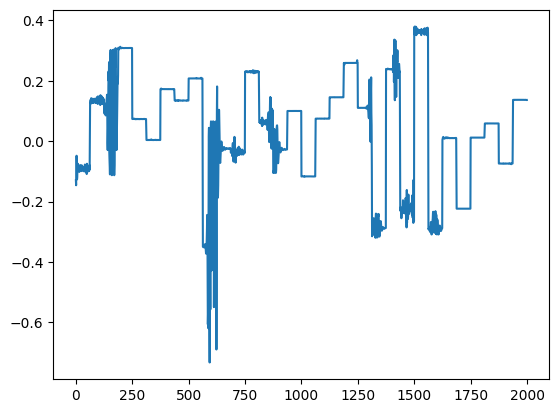

In [26]:
plt.plot(x_p[1])

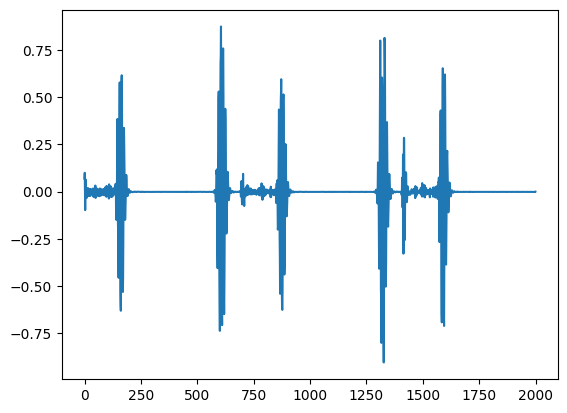

In [27]:
plt.plot(x[1])

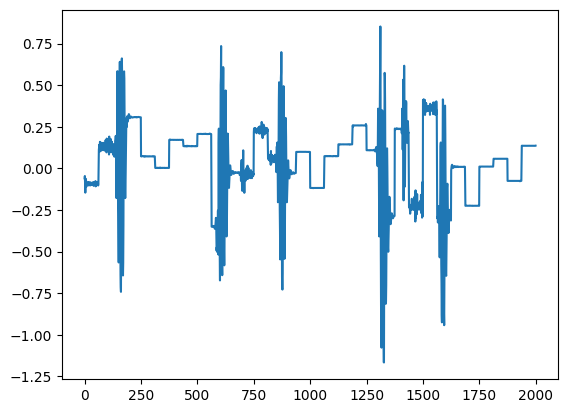

In [29]:
plt.plot(x[1]+x_p[1])